In [1]:
function setrand()
    s = rand(1:1000)
    println("s = ", s)
    srand(s)
end

function loaddata(n)
    d = 2   # dimension of u space
    s = 1.4  # mean separation factor

    fracs = [0.5, 0.5]     # fraction in the different classes
    K = length(fracs)      # number of classes

    # square roots of covariances
    covs = Any[]
    for i=1:K
        A = randn(2,2)
        D,V = eig(A*A')
        D2 = [randn()+0.7  0; 0 randn()+0.7]
        push!(covs, V*D2*V')
    end

    # assign categories according to fractions
    cfracs = cumsum(fracs)
    cats = zeros(Int64,n)
    c = 1
    for i=1:n
        if i/n > cfracs[c]
            c += 1
        end
        cats[i] = c
    end
    
    # choose the means of each cluster
    means = zeros(d,K)
    for i=1:K
        means[:,i] = s*randn(d)
    end
    
    # assign U and V
    U = zeros(n,d)
    V = zeros(n)
    for i=1:n
        c = cats[i]
        V[i] = c 
        x = (means[:,c] + covs[c]*randn(d))'
        U[i,:] = x
    end

    Unew, Vnew = normalizedata(U,V)
    return Unew, Vnew, K
end

function normalizedata(U,V)
    n = size(U,1)
    xmin = minimum(U[:,1]) - 0.1
    xmax = maximum(U[:,1]) + 0.1
    ymin = minimum(U[:,2]) - 0.1
    ymax = maximum(U[:,2]) + 0.1
    m = 0.5*[ xmax+xmin ymax+ymin]
    Unew = U - repmat(m, n, 1)
    Unew[:,1] = Unew[:,1] * 8/(xmax-xmin)
    Unew[:,2] = Unew[:,2] * 8/(ymax-ymin)
    return Unew, V
end


normalizedata (generic function with 1 method)

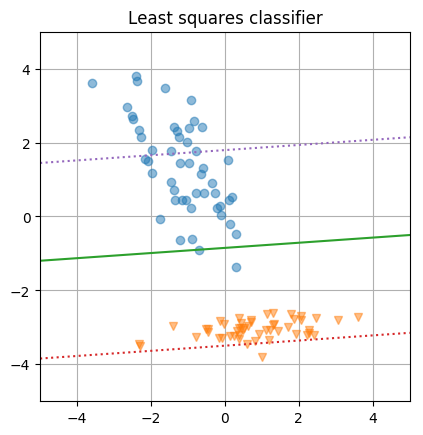

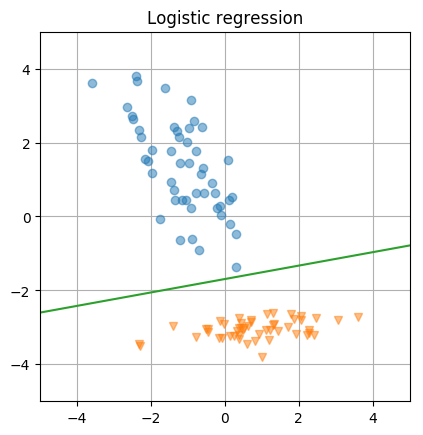

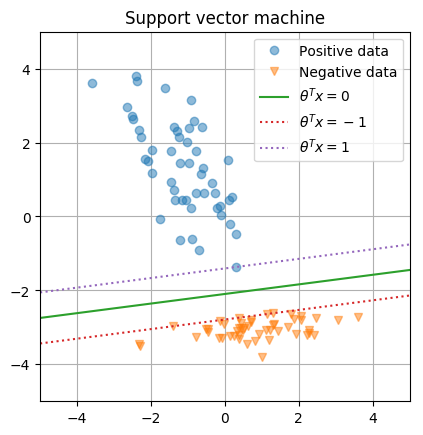

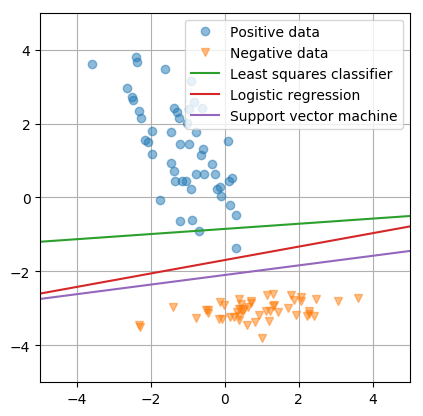

(-5, 5)


ECOS 2.0.5 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  -2.285e-18  -2.614e+00  +1e+01  5e-01  1e-01  1e+00  2e+00    ---    ---    1  1  - |  -  - 
 1  -7.846e-02  -1.996e-01  +1e+00  4e-02  1e-02  2e-01  2e-01  0.9056  5e-02   1  1  1 |  0  0
 2  -1.130e-02  -4.688e-02  +4e-01  1e-02  3e-03  6e-02  7e-02  0.7768  1e-01   1  1  2 |  0  0
 3  +2.707e-01  +8.523e-01  +4e-01  1e+00  4e-02  3e+00  6e-02  0.6679  6e-01   2  2  2 |  0  0
 4  +2.370e+00  +2.425e+00  +2e-02  5e-02  2e-03  2e-01  3e-03  0.9890  4e-02   2  2  2 |  0  0
 5  +5.513e+00  +6.267e+00  +3e-03  3e-02  1e-03  8e-01  5e-04  0.9540  1e-01   3  2  2 |  0  0
 6  +9.960e+00  +1.039e+01  +1e-03  8e-03  3e-04  4e-01  2e-04  0.9890  3e-01   3  3  2 |  0  0
 7  +1.315e+01  +1.352e+01  +2e-04  3e-03  1e-04  4e-01  4e-05  0.8603  1e-01   4  3  3 |  0  0
 8  +1.438e+01  +1.442e+01  +3e-05  5e-04  2e-

/usr/local/lib/python2.7/dist-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


In [2]:
using PyPlot, Convex, ECOS

srand(323)
#srand(999)
U,V,K = loaddata(100)
n = length(V)
X = [ones(n) U]
y = V
y[V.==2] = -1 

U_p = U[y.==1,:]
U_n = U[y.==-1,:]

## least squares classifier

theta = Variable(3);
obj = sumsquares(1-y.*(X*theta)) + 0.1*sumsquares(theta[2:end])
#obj = sumsquares(X*theta-y) + 0.1*sumsquares(theta[2:end])
problem = minimize(obj)
solve!(problem, ECOSSolver())
theta_opt = evaluate(theta)

# separating plane
s1 = -5:0.1:5
s2 = - ( theta_opt[1] + s1*theta_opt[2] ) / theta_opt[3]
s2p = - (  1 + theta_opt[1] + s1*theta_opt[2] ) / theta_opt[3]
s2n = - ( -1 + theta_opt[1] + s1*theta_opt[2] ) / theta_opt[3]
s2_ls = s2

figure()
plot(U_p[:,1], U_p[:,2], "o", alpha=0.5)
plot(U_n[:,1], U_n[:,2], "v", alpha=0.5)
plot(s1,s2)
plot(s1,s2p, ":")
plot(s1,s2n, ":")
grid("on")
axis("square")
xlim(-5, 5)
ylim(-5, 5)
title("Least squares classifier")

## logistic regression

theta = Variable(3);
obj = logisticloss(-y.*(X*theta)) + 0.1*sumsquares(theta[2:end])
problem = minimize(obj)
solve!(problem, ECOSSolver())
theta_opt = evaluate(theta)

# separating plane
s1 = -5:0.1:5
s2 = - ( theta_opt[1] + s1*theta_opt[2] ) / theta_opt[3]
s2_lr = s2

figure()
plot(U_p[:,1], U_p[:,2], "o", alpha=0.5)
plot(U_n[:,1], U_n[:,2], "v", alpha=0.5)
plot(s1,s2)
grid("on")
axis("square")
xlim(-5, 5)
ylim(-5, 5)
title("Logistic regression")

## support vector machine

theta = Variable(3);
obj = sum(max(0,1-y.*(X*theta))) + 0.1*sumsquares(theta[2:end])
problem = minimize(obj)
solve!(problem, ECOSSolver())
theta_opt = evaluate(theta)

# separating plane
s1 = -5:0.1:5
s2 = - ( theta_opt[1] + s1*theta_opt[2] ) / theta_opt[3]
s2p = - (  1 + theta_opt[1] + s1*theta_opt[2] ) / theta_opt[3]
s2n = - ( -1 + theta_opt[1] + s1*theta_opt[2] ) / theta_opt[3]
s2_svm = s2

figure()
plot(U_p[:,1], U_p[:,2], "o", alpha=0.5, label="Positive data")
plot(U_n[:,1], U_n[:,2], "v", alpha=0.5, label="Negative data")
plot(s1,s2, label=L"$\theta^Tx=0$")
plot(s1,s2p, ":", label=L"$\theta^Tx=-1$")
plot(s1,s2n, ":", label=L"$\theta^Tx=1$")
grid("on")
axis("square")
legend()
xlim(-5, 5)
ylim(-5, 5)
title("Support vector machine")

figure()
plot(U_p[:,1], U_p[:,2], "o", alpha=0.5, label="Positive data")
plot(U_n[:,1], U_n[:,2], "v", alpha=0.5, label="Negative data")
plot(s1,s2_ls, label="Least squares classifier")
plot(s1,s2_lr, label="Logistic regression")
plot(s1,s2_svm, label="Support vector machine")
grid("on")
axis("square")
legend()
xlim(-5, 5)
ylim(-5, 5)